*Автор: Петухов Дмитрий*<br />
*Дата: 17.01.2018*

<center>
# Идентификация пользователя по его поведению в сети Интернет

Идентификация пользователя по его поведению в сети Интернет – это сложная и интересная задача на стыке анализа данных и поведенческой психологии. Эта задача решается как IT-гигантами, так стартапами и научными коллективами. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. Взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. 


<img src="detection.jpeg" width="800" align="center"/>

# 1. Цели и задачи проекта, описание исходных и обработанных данных и признаков.

Мы будем решать похожую задачу: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

В проекте мы будем использовать данные из [соревнования](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass. Данные для соревнования взяты соответственно из [статьи](http://ceur-ws.org/Vol-1703/paper12.pdf) "A Tool for Classification of Sequential Data". Имеются данные с прокси-серверов Университета Блеза Паскаля, они имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате: <br>

<center>*timestamp, посещенный веб-сайт*</center>

В этом соревновании будем решать следующую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).
Для соревнования исходные данные преобразованы в следующий формат:

В обучающей выборке *train_sessions.csv*:

Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем *site_dic.pkl*)<br>
Признаки time_j – время посещения сайтов site_j<br>
Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)<br><br>
Задача – сделать прогнозы для сессий в тестовой выборке (*test_sessions.csv*), определить, принадлежат ли они Элис. Не обязательно ограничиваться только предложенной выборкой *train_sessions.csv* – в train.zip даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.<br>

Целевая метрика – ROC AUC

In [95]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки) и посмотрим на данные в первом приближении.

In [2]:
train_df = pd.read_csv('data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv', index_col='session_id')

train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [9]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35,2014-10-04 11:19:53,22,2014-10-04 11:19:54,321,2014-10-04 11:19:54,23,2014-10-04 11:19:54,2211,2014-10-04 11:19:54,6730,2014-10-04 11:19:54,21,2014-10-04 11:19:54,44582,2014-10-04 11:20:00,15336,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782,2014-07-03 11:00:53,782,2014-07-03 11:00:58,782,2014-07-03 11:01:06,782,2014-07-03 11:01:09,782,2014-07-03 11:01:10,782,2014-07-03 11:01:23,782,2014-07-03 11:01:29,782,2014-07-03 11:01:30,782,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55,2014-12-05 15:55:13,55,2014-12-05 15:55:14,55,2014-12-05 15:56:15,55,2014-12-05 15:56:16,55,2014-12-05 15:56:17,55,2014-12-05 15:56:18,55,2014-12-05 15:56:19,1445,2014-12-05 15:56:33,1445,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022,2014-11-04 10:03:19,50,2014-11-04 10:03:20,222,2014-11-04 10:03:21,202,2014-11-04 10:03:21,3374,2014-11-04 10:03:22,50,2014-11-04 10:03:22,48,2014-11-04 10:03:22,48,2014-11-04 10:03:23,3374,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301,2014-05-16 15:05:32,301,2014-05-16 15:05:33,66,2014-05-16 15:05:39,67,2014-05-16 15:05:40,69,2014-05-16 15:05:40,70,2014-05-16 15:05:40,68,2014-05-16 15:05:40,71,2014-05-16 15:05:40,167,2014-05-16 15:05:44


В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 
Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.<br>

# 2. Первичный анализ признаков

Посмотрим на статистику признаков в обеих выборках.

In [90]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [91]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


Распределение целевой переменной:

In [11]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.

In [15]:
print('Доля сессий Элис: ', round(2297/251264 * 100, 3), '%')

Доля сессий Элис:  0.914 %


Видим, что доля сессий Элис в обучающей выборке менее 1%

# 3. Визуальный анализ признаков

In [101]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

Посмотрим на распределение целевой переменной

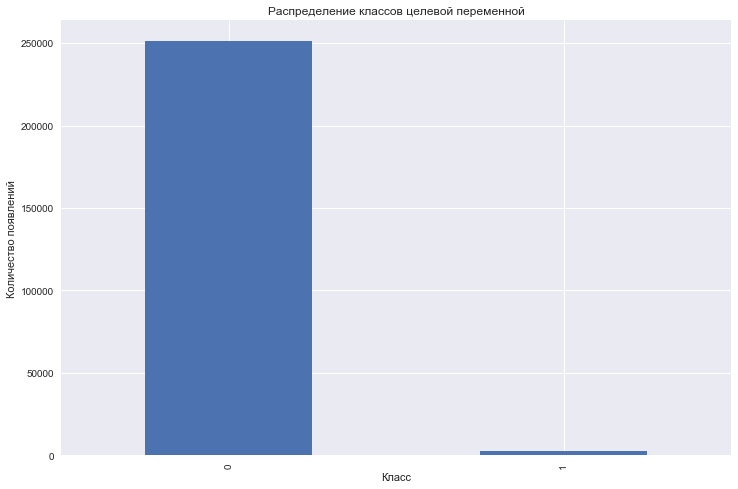

In [49]:
train_df['target'].value_counts().plot(kind='bar', label='target');
plt.title('Распределение классов целевой переменной')
plt.xlabel('Класс')
plt.ylabel('Количество появлений');

Теперь посмотрим, за какие года у нас данные в тренировочной и тестовой частях:

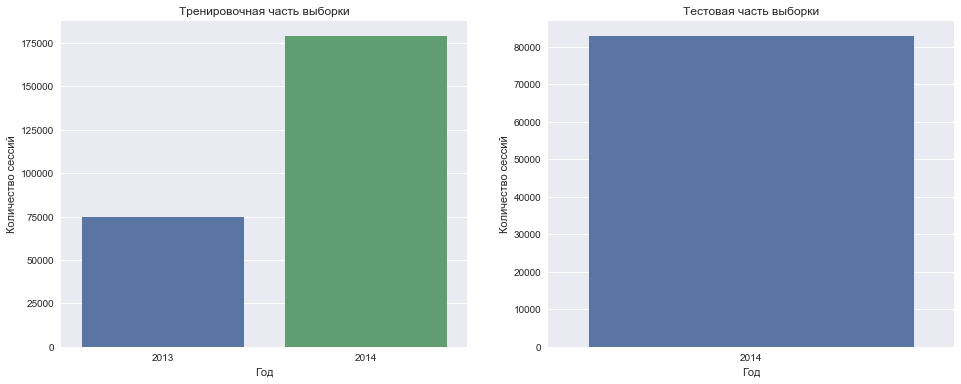

In [72]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(x=train_df['time1'].apply(lambda x: x.year), data=train_df, ax=axes[0])
sns.countplot(x=test_df['time1'].apply(lambda x: x.year), data=test_df, ax=axes[1])
axes[0].set(xlabel='Год', ylabel='Количество сессий', title='Тренировочная часть выборки')
axes[1].set(xlabel='Год', ylabel='Количество сессий', title='Тестовая часть выборки');

Видим, что в тестовой части выборки данные только за 2014 год.<br>
Посмотрим на распределение данных по месяцам в тренировочной части выборки для класса целевой переменной "0" - не Элис:

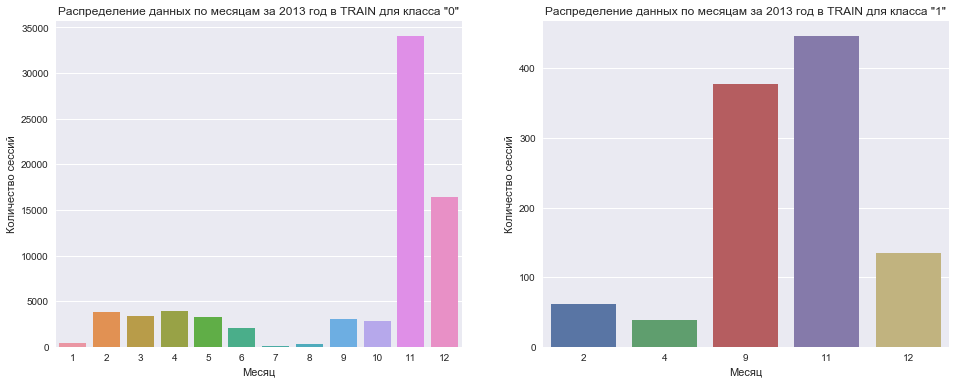

In [78]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
tmp_df = train_df[train_df['time1'].apply(lambda x: x.year)==2013][train_df.target==0]
sns.countplot(x=tmp_df['time1'].apply(lambda x: x.month), data=tmp_df, ax=axes[0])
tmp_df = train_df[train_df['time1'].apply(lambda x: x.year)==2013][train_df.target==1]
sns.countplot(x=tmp_df['time1'].apply(lambda x: x.month), data=tmp_df, 
              ax=axes[1])
axes[0].set(xlabel='Месяц', ylabel='Количество сессий', title='Распределение данных по месяцам за 2013 год в TRAIN для класса "0"')
axes[1].set(xlabel='Месяц', ylabel='Количество сессий', title='Распределение данных по месяцам за 2013 год в TRAIN для класса "1"');

Видим, что за 2013 год в тестовой выборке присутствует данные по всем месяцам, причем наибольшее количество сессий приходится на ноябрь и декабрь. Также видна одна особенность - в 2013 году в некоторых месяцах сессий Элис нет. Это очень интересно и можно будет использовать в дальнейшем. Теперь посмотрим на распределение данных тренировочной части выборки по месяцам 2014 года:

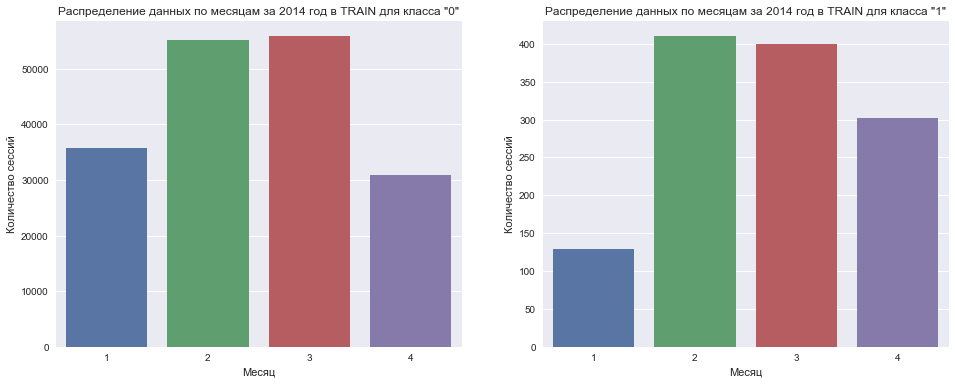

In [79]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
tmp_df = train_df[train_df['time1'].apply(lambda x: x.year)==2014][train_df.target==0]
sns.countplot(x=tmp_df['time1'].apply(lambda x: x.month), data=tmp_df, ax=axes[0])
tmp_df = train_df[train_df['time1'].apply(lambda x: x.year)==2014][train_df.target==1]
sns.countplot(x=tmp_df['time1'].apply(lambda x: x.month), data=tmp_df, 
              ax=axes[1])
axes[0].set(xlabel='Месяц', ylabel='Количество сессий', title='Распределение данных по месяцам за 2014 год в TRAIN для класса "0"')
axes[1].set(xlabel='Месяц', ylabel='Количество сессий', title='Распределение данных по месяцам за 2014 год в TRAIN для класса "1"');

Видим, что за 2014 в тренировочной части присутствуют данные за период январь-апрель, причем сессии распределены относительно равномерно по этим месяцам. Теперь посмотрим на распределение данных по месяцам в тестовой части выборки:

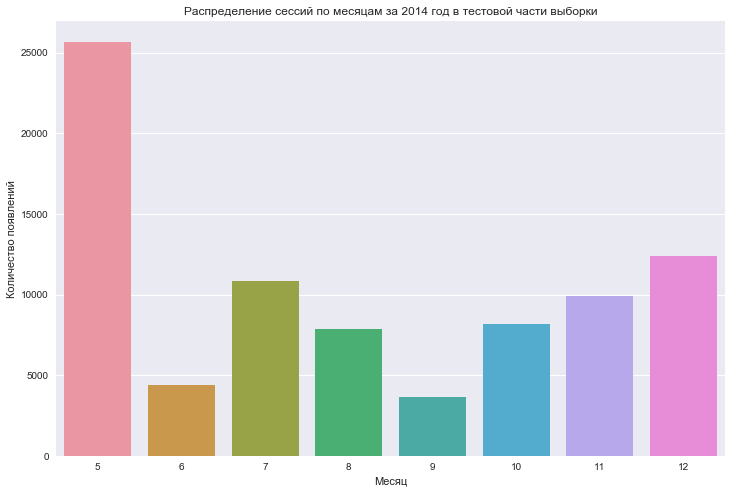

In [80]:
ax = sns.countplot(x=test_df['time1'].apply(lambda x: x.month), data=test_df)
ax.set(xlabel='Месяц', ylabel='Количество появлений', title='Распределение сессий по месяцам за 2014 год в тестовой части выборки');

Видим, что за 2014 год присутствует данные за период май-декабрь, причем наибольшее количество сессий приходится на май.<br>
Давайте теперь посмотрим на распределение сессий по часу начала сессии.

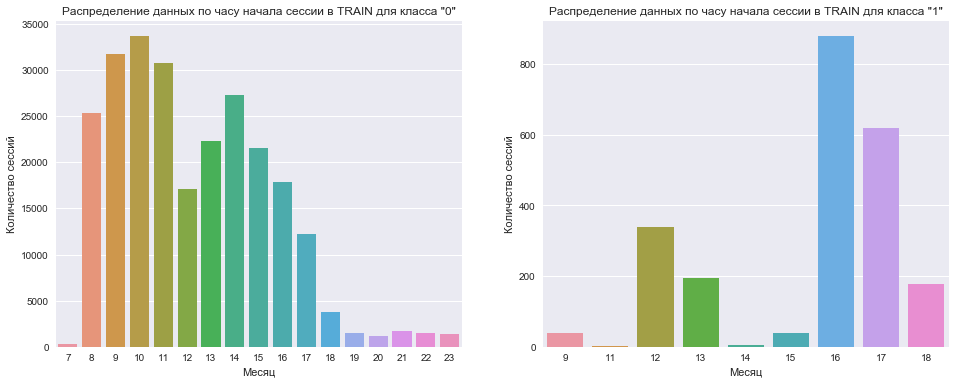

In [82]:
_, axes = plt.subplots(1, 2, figsize=(16,6))
tmp_df = train_df[train_df.target==0]
sns.countplot(x=tmp_df['time1'].apply(lambda x: x.hour), data=tmp_df, ax=axes[0])
tmp_df = train_df[train_df.target==1]
sns.countplot(x=tmp_df['time1'].apply(lambda x: x.hour), data=tmp_df, ax=axes[1])
axes[0].set(xlabel='Час', ylabel='Количество сессий', title='Распределение данных по часу начала сессии в TRAIN для класса "0"')
axes[1].set(xlabel='Час', ylabel='Количество сессий', title='Распределение данных по часу начала сессии в TRAIN для класса "1"');

Видно, что все сессии приходятся на промежуток с 7 часов утра до 23 часов вечера.
Здесь мы видим еще одну интересную особенность - Элис бывает в сети Интернет только в определенные часы.
Теперь посмотрим на распределение данных по часам в тестовой части выборки:

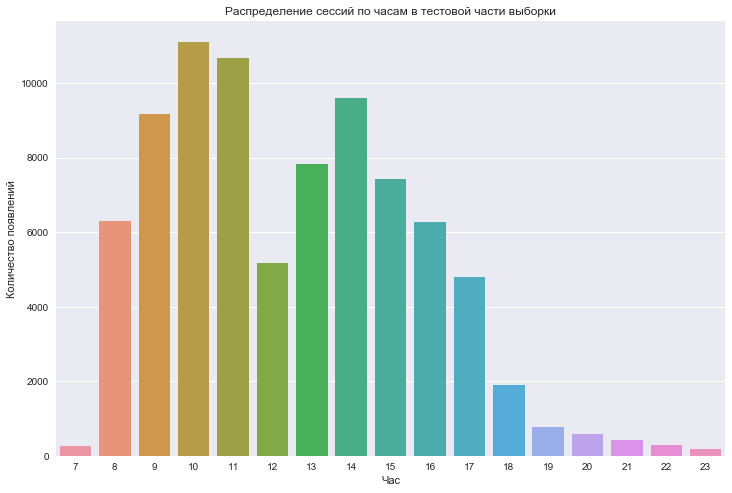

In [83]:
ax = sns.countplot(x=test_df['time1'].apply(lambda x: x.hour), data=test_df)
ax.set(xlabel='Час', ylabel='Количество появлений', title='Распределение сессий по часам в тестовой части выборки');

Видно, что все сессии также приходятся на промежуток с 7 часов утра до 23 часов вечера.
Распределение по часам в тестовой части соответствует распределению по часам в тренировочной части выборки, это хорошо.

**Вывод по визуальному анализу данных:**
Мы обнаружили довольно интересные инсайты и нашли некоторые закономерности в данных, которые описали выше. 

Теперь пришло время создать новые признаки.

# 4. Предобработка данных и создание признаков

Для начала преобразуем признаки time1 - time10 во временной формат и заполним пропуски нулями. Индексы сайтов приведем к целочисленному формату, пропуски также заполним нулями (индексы посещенных сайтов начинаются с единицы).

In [3]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].fillna(0).apply(pd.to_datetime)
test_df[times] = test_df[times].fillna(0).apply(pd.to_datetime)

Объединим тренировочную и тестовую выборки:

In [4]:
idx_split = len(train_df)
train_test_df = pd.concat([train_df, test_df])

Добавим признак "Длинна сессии". Ранее мы заполнили признак time10 нулями. Так как признак имеет временной формат, то ноль будет соответствовать дате 01-01-1970. Нам это и нужно. Найдем разницу значений time10 и time1 в секундах. Если длина сессии 30 минут, то получившееся значение будет отрицательным. 

In [5]:
train_test_df['time10'].fillna(0, inplace=True)
train_test_df['session_time'] = (train_test_df['time10'] - train_test_df['time1']).astype('timedelta64[s]').astype('int')
train_test_df['session_time'] = train_test_df['session_time'].apply(lambda x: 108000 if x<0 else x)
train_test_df.head(5)

,site1,site10,site2,site3,site4,site5,site6,site7,site8,site9,...,time10,time2,time3,time4,time5,time6,time7,time8,time9,session_time
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0,...,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,108000
2,890,1518,941,3847,941,942,3846,3847,3846,1516,...,2014-02-22 11:20:16,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,26
3,14769,14768,39,14768,14769,37,39,14768,14768,14768,...,2013-12-16 16:40:24,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,7
4,782,782,782,782,782,782,782,782,782,782,...,2014-03-28 10:56:42,2014-03-28 10:52:42,2014-03-28 10:53:12,2014-03-28 10:53:42,2014-03-28 10:54:12,2014-03-28 10:54:42,2014-03-28 10:55:12,2014-03-28 10:55:42,2014-03-28 10:56:12,270
5,22,178,177,175,178,177,178,175,177,177,...,2014-02-28 10:57:11,2014-02-28 10:55:22,2014-02-28 10:55:22,2014-02-28 10:55:23,2014-02-28 10:55:23,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:57:06,246


Теперь добавим следующие признаки:
- день недели начала сессии
- месяц начала сессии
- час начала сессии
- год-месяц (мы помним, что сессии элис присутствуют не во всех месяцах 2013 года)
- час в который Элис бывает в сети Интернет

In [6]:
alice_hour = [9,11,12,13,14,15,16,17,18]
train_test_df['dow'] = train_test_df['time1'].apply(lambda x: x.dayofweek)
train_test_df['month'] = train_test_df['time1'].apply(lambda x: x.month)
train_test_df['hour'] = train_test_df['time1'].apply(lambda x: x.hour)
train_test_df['year_month'] = train_test_df['time1'].apply(lambda x: 100 * x.year + x.month)
train_test_df['is_alice_hour'] = train_test_df['hour'].apply(lambda x: 1 if x in alice_hour else 0)

In [7]:
train_test_df.head()

,site1,site10,site2,site3,site4,site5,site6,site7,site8,site9,...,time6,time7,time8,time9,session_time,dow,month,hour,year_month,is_alice_hour
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0,...,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,108000,3,2,10,201402,0
2,890,1518,941,3847,941,942,3846,3847,3846,1516,...,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,26,5,2,11,201402,1
3,14769,14768,39,14768,14769,37,39,14768,14768,14768,...,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,7,0,12,16,201312,1
4,782,782,782,782,782,782,782,782,782,782,...,2014-03-28 10:54:42,2014-03-28 10:55:12,2014-03-28 10:55:42,2014-03-28 10:56:12,270,4,3,10,201403,0
5,22,178,177,175,178,177,178,175,177,177,...,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:57:06,246,4,2,10,201402,0


Создадим разреженные матрицы *X_train_sparse* и *X_test_sparse* для сайтов. Также выделим в отдельный вектор *y* ответы на обучающей выборке.

In [12]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]]
sites_flatten = train_test_df_sites.values.flatten()
train_test_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

X_train_sparse = train_test_sparse[:train_df.shape[0]]
X_test_sparse = train_test_sparse[train_df.shape[0]:]
y = train_df['target'].values

Применим к категориальным признакам OHE и отмасштабируем признак "длина сессии". Линейные модели очень к этому чувствительны.

In [9]:
train_test_features_df = train_test_df[['dow', 'month', 'hour', 'year_month', 'is_alice_hour', 'session_time']]
train_test_features_df['session_time'] = np.log1p(train_test_features_df['session_time'].values)
train_test_features_df = pd.get_dummies(train_test_features_df, columns = ['dow','month','hour', 'year_month'], 
                                           prefix=['col_{}'.format(i) for i in range(4)], sparse=False)
new_feat_train = train_test_features_df.iloc[:idx_split, :]
new_feat_test = train_test_features_df.iloc[idx_split:, :]

In [10]:
train_test_features_df.head()

,is_alice_hour,session_time,col_0_0,col_0_1,col_0_2,col_0_3,col_0_4,col_0_5,col_0_6,col_1_1,...,col_3_201403,col_3_201404,col_3_201405,col_3_201406,col_3_201407,col_3_201408,col_3_201409,col_3_201410,col_3_201411,col_3_201412
session_id,,,,,,,,,,,,,,,,,,,,,
1,0,11.589896,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3.295837,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2.079442,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,5.602119,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,5.509388,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Объединим разреженную матрицу сайтов и новые признаки:

In [13]:
X_train_sparse = csr_matrix(hstack([X_train_sparse, new_feat_train]))
X_test_sparse = csr_matrix(hstack([X_test_sparse, new_feat_test]))

X_train_sparse.shape, X_test_sparse.shape

((253561, 48433), (82797, 48433))

# 5. Выбор алгоритма, кросс-валидация, построение кривых валидации и обучения.

Вспомогательная функция для отрисовки кривых валидации:

In [96]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()
    
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

Зададим параметры кросс-валидации: стратифицированное разбиение по пяти фолдам, перемешивать данные. Не забываем указать random state (для воспроизводимости).

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

У нас выборка с большим пространством признаков, поэтому будем использовать следуюшие три линейных алгоритма:

In [18]:
sgd = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
logit = LogisticRegression(C=1.0, random_state=17, n_jobs=-1)
svm = LinearSVC(C=1, random_state=17)

Обучим модель SGDClassifier и посмотрим на среднее значение ROC AUC по фолдам:

In [27]:
%%time
print('Значение ROC AUC для SGDClassifier: ', 
      round(cross_val_score(sgd, X_train_sparse, y, cv=skf, scoring='roc_auc').mean(),6))

Значение ROC AUC для SGDClassifier:  0.976916
Wall time: 3.42 s


Обучим модель LogisticRegression и посмотрим на среднее значение ROC AUC по фолдам:

In [28]:
%%time
print('Значение ROC AUC для LogisticRegression: ', 
      round(cross_val_score(logit, X_train_sparse, y, cv=skf, scoring='roc_auc').mean(),6))

Значение ROC AUC для LogisticRegression:  0.989622
Wall time: 52.2 s


Обучим модель LinearSVC и посмотрим на среднее значение ROC AUC по фолдам:

In [29]:
%%time
print('Значение ROC AUC для LinearSVC: ', 
      round(cross_val_score(svm, X_train_sparse, y, cv=skf, scoring='roc_auc').mean(),6))

Значение ROC AUC для LinearSVC:  0.98649
Wall time: 30.4 s


**Подберем наилучшие гиперпараметры для наших моделей.** 

С помощью `GridSearchCV` подберем параметр `alpha` для SGDClassifier: 10 значений от 0.00001 до 0.0003, будем использовать `linspace` из NumPy.

In [68]:
%%time
sgd_params = {'alpha': np.linspace(0.00001, 0.0001, 10)}

sgd_grid_searcher = GridSearchCV(sgd, sgd_params, scoring='roc_auc', n_jobs=-1, cv=skf)
sgd_grid_searcher.fit(X_train_sparse, y)

Wall time: 36.9 s


Выведем лучшее значение ROC-AUC на кросс-валидации и соответствующее значение alpha.

In [85]:
print('Лучшее значение ROC AUC для SGDClassifier: {}, при параметре alpha: {}'.format('%.6f' % sgd_grid_searcher.best_score_, 
                                                                    '%.7f' % sgd_grid_searcher.best_params_['alpha']))

Лучшее значение ROC AUC для SGDClassifier: 0.983575, при параметре alpha: 0.0000200


Нарисуем кривые валидации:

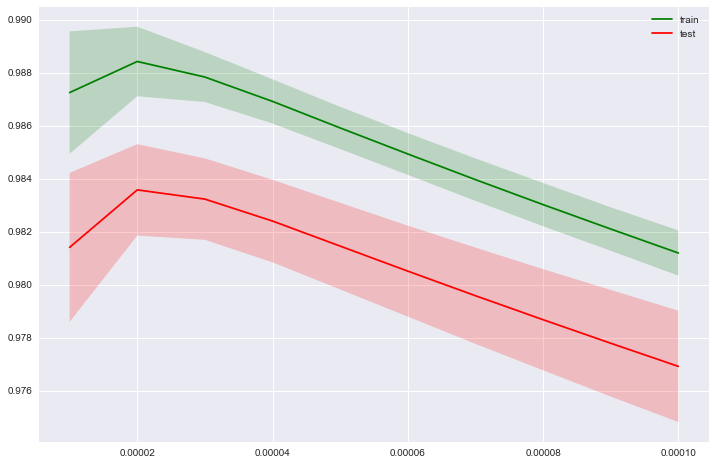

In [73]:
plot_validation_curves(sgd_params['alpha'], sgd_grid_searcher.cv_results_)

С помощью LogisticRegressionCV подберем параметр C для LogisticRegression: 10 значений от 0.1 до 5, будем использовать linspace из NumPy.

In [75]:
%%time
logit_c_values = np.linspace(0.1, 5, 10)

logit_grid_searcher = LogisticRegressionCV(Cs=logit_c_values, cv=skf, random_state=17, n_jobs=-1, scoring='roc_auc')
logit_grid_searcher.fit(X_train_sparse, y)

Wall time: 4min 56s


In [77]:
logit_mean_cv_scores = np.zeros(len(logit_c_values))
for i in logit_grid_searcher.scores_[1]: 
    logit_mean_cv_scores  += np.array(i)          
logit_mean_cv_scores = logit_mean_cv_scores / 5            
logit_mean_cv_scores

array([ 0.9843716 ,  0.98939464,  0.98995103,  0.99013843,  0.99021325,
        0.99024071,  0.99023293,  0.99021531,  0.99018601,  0.99015377])

Выведем лучшее значение ROC-AUC на кросс-валидации и соответствующее значение C.

In [86]:
print('Лучшее значение ROC AUC для LogisticRegression: {}, при параметре C: {}'.format('%.6f' % logit_mean_cv_scores.max(), 
                                                                '%.3f' % logit_grid_searcher.Cs_[logit_mean_cv_scores.argmax()]))

Лучшее значение ROC AUC для LogisticRegression: 0.990241, при параметре C: 2.822


Нарисуем график зависимости значения ROC AUC на кросс-валидации от C

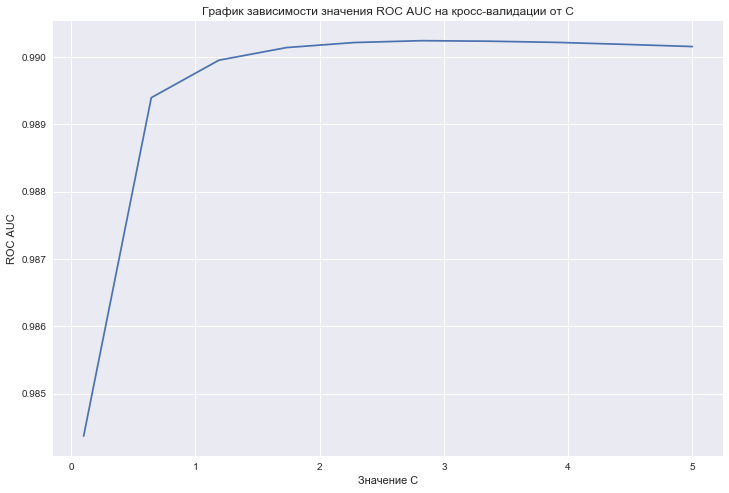

In [89]:
plt.plot(logit_c_values, logit_mean_cv_scores)
plt.title('График зависимости значения ROC AUC на кросс-валидации от C')
plt.xlabel('Значение С')
plt.ylabel('ROC AUC');

С помощью GridSearchCV подберем параметр C для LinearSVC: 10 значений от 0.00001 до 0.0003, будем использовать linspace из NumPy.

In [92]:
%%time
svm_params = {'C': np.linspace(0.001, 1, 10)}

svm_grid_searcher = GridSearchCV(svm, svm_params, scoring='roc_auc', n_jobs=-1, cv=skf)
svm_grid_searcher.fit(X_train_sparse, y)

Wall time: 3min 5s


Выведем лучшее значение ROC-AUC на кросс-валидации и соответствующее значение C.

In [93]:
print('Лучшее значение ROC AUC для LinearSVC: {}, при параметре C: {}'.format('%.6f' % svm_grid_searcher.best_score_, 
                                                                    '%.7f' % svm_grid_searcher.best_params_['C']))

Лучшее значение ROC AUC для LinearSVC: 0.988207, при параметре C: 0.1120000


Нарисуем кривые валидации:

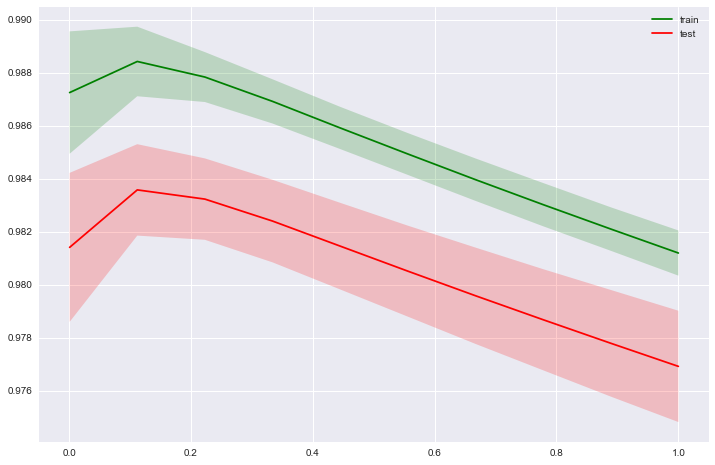

In [94]:
plot_validation_curves(svm_params['C'], sgd_grid_searcher.cv_results_)

Построим кривые обучения для модели LinearSVC. 

In [98]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_sparse, y, train_sizes=train_sizes, cv=skf,
                                             scoring='roc_auc', random_state=17)

Wall time: 3min 4s


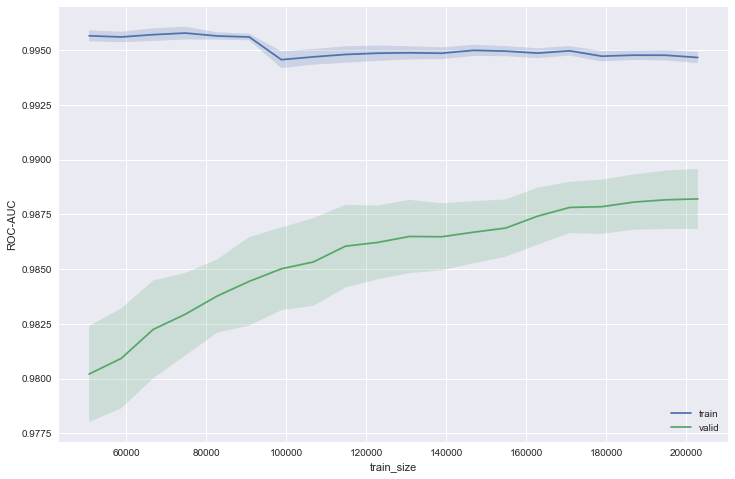

In [102]:
plt.figsize=(14, 7)
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='ROC-AUC')

По кривым обучения можно сделать вывод, что алгоритму помогут новые размеченные данные.

# 6. Оценка модели с описанием выбранной метрики. 

На кросс-валидации наилучшее качество показал алгоритм LogisticRegression. При его использовании метрика ROC AUC максимальна. Напомним, что метрика ROC AUC - это площадь под кривой зависимости True Positive Rate от False Positive Rate. В зависимости от выбранного нами treshold на этой кривой мы будем получать то или иное значение точности при соответствующем значении полноты.

Обучим выбранный алгоритм и сделаем submission на Kaggle.

In [103]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):

    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [114]:
logit = LogisticRegression(C=logit_grid_searcher.Cs_[logit_mean_cv_scores.argmax()], random_state=17, n_jobs=-1)
y_pred = logit.fit(X_train_sparse, y).predict_proba(X_test_sparse)[:,1]
write_to_submission_file(y_pred, 'submission.csv')

In [3]:
from PIL import Image
im = Image.open('img/report.png')
im.show()

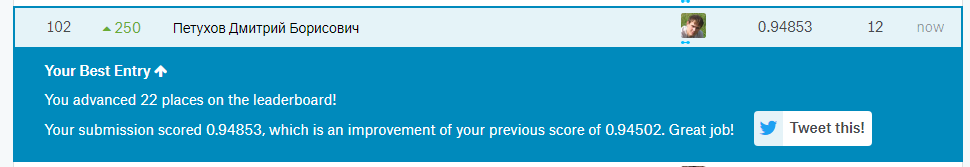

In [4]:
from IPython.display import Image
Image(filename='img/report.png')

Мы получили значение ROC AUC на тестовой выборке 0.94853. Это очень хороший результат.

# 7. Выводы. 

Наша обученная модель показала очень хороший результат на тестовой выборке. Что еще можно сделать для улучшение предсказательного качества модели? Пути улучшения:

1. Добавить новые признаки
2. Сделать ансамбль моделей
3. Изменить ширину окна сессий
4. Взять больше данных

Построенную модель можно вполне успешно применять на практике. Например, мы можем с большой степенью уверенности идентифицировать пользователя, использующего тот или иной сервис в сети Интернет. Это позволит определять несанкционированный доступ к тем или иным ресурсам.

1. Помимо явного создания разреженного формата можно еще составить выборки с помощью CountVectorizer, TfidfVectorizer и т.п. Поскольку данные по сути могут быть описаны как последовательности, то можно вычислять n-граммы сайтов.
2. Сайты привести к виду site.dom